In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr  
import datetime
import seaborn as sns
import numpy as np
from arch import arch_model
import torch.nn as nn
import torch
import math
import torch.nn.functional as F


# Data Read

In [2]:
df = pd.read_excel("SP500_data.xlsx", parse_dates=True, index_col= 0)

In [3]:
print(df)

            SP500_Close        VIX  DGS10        Oil         Gold
Date                                                             
2001-01-02  1283.270020  29.990000   5.11  27.200001   268.399994
2001-01-03  1347.560059  26.600000   4.92  27.950001   268.000000
2001-01-04  1333.339966  26.969999   5.14  28.200001   267.299988
2001-01-05  1298.349976  28.670000   5.03  28.000000   268.000000
2001-01-08  1295.859985  29.840000   4.93  27.350000   268.000000
...                 ...        ...    ...        ...          ...
2024-12-23  5974.069824  16.780001   4.31  70.599998  2617.199951
2024-12-24  6040.040039  14.270000   4.27  70.599998  2617.199951
2024-12-26  6037.589844  14.730000   4.24  70.599998  2617.199951
2024-12-27  5970.839844  15.950000   4.30  70.599998  2617.199951
2024-12-30  5906.939941  17.400000   5.11  70.599998  2617.199951

[6036 rows x 5 columns]


In [4]:
print(df.head())

            SP500_Close        VIX  DGS10        Oil        Gold
Date                                                            
2001-01-02  1283.270020  29.990000   5.11  27.200001  268.399994
2001-01-03  1347.560059  26.600000   4.92  27.950001  268.000000
2001-01-04  1333.339966  26.969999   5.14  28.200001  267.299988
2001-01-05  1298.349976  28.670000   5.03  28.000000  268.000000
2001-01-08  1295.859985  29.840000   4.93  27.350000  268.000000


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6036 entries, 2001-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SP500_Close  6036 non-null   float64
 1   VIX          6036 non-null   float64
 2   DGS10        6036 non-null   float64
 3   Oil          6036 non-null   float64
 4   Gold         6036 non-null   float64
dtypes: float64(5)
memory usage: 282.9 KB
None


In [6]:
print(df.describe())

       SP500_Close          VIX        DGS10          Oil         Gold
count  6036.000000  6036.000000  6036.000000  6036.000000  6036.000000
mean   2139.979443    19.729506     3.211186    65.146148  1176.800911
std    1260.073035     8.581434     1.243155    24.916403   578.423760
min     676.530029     9.140000     0.520000   -37.630001   255.100006
25%    1191.377502    13.740000     2.180000    46.349998   650.599976
50%    1525.585022    17.520000     3.150000    64.389999  1240.049988
75%    2798.095032    23.030001     4.260000    83.145000  1628.975006
max    6090.270020    82.690002     5.540000   145.289993  2788.500000


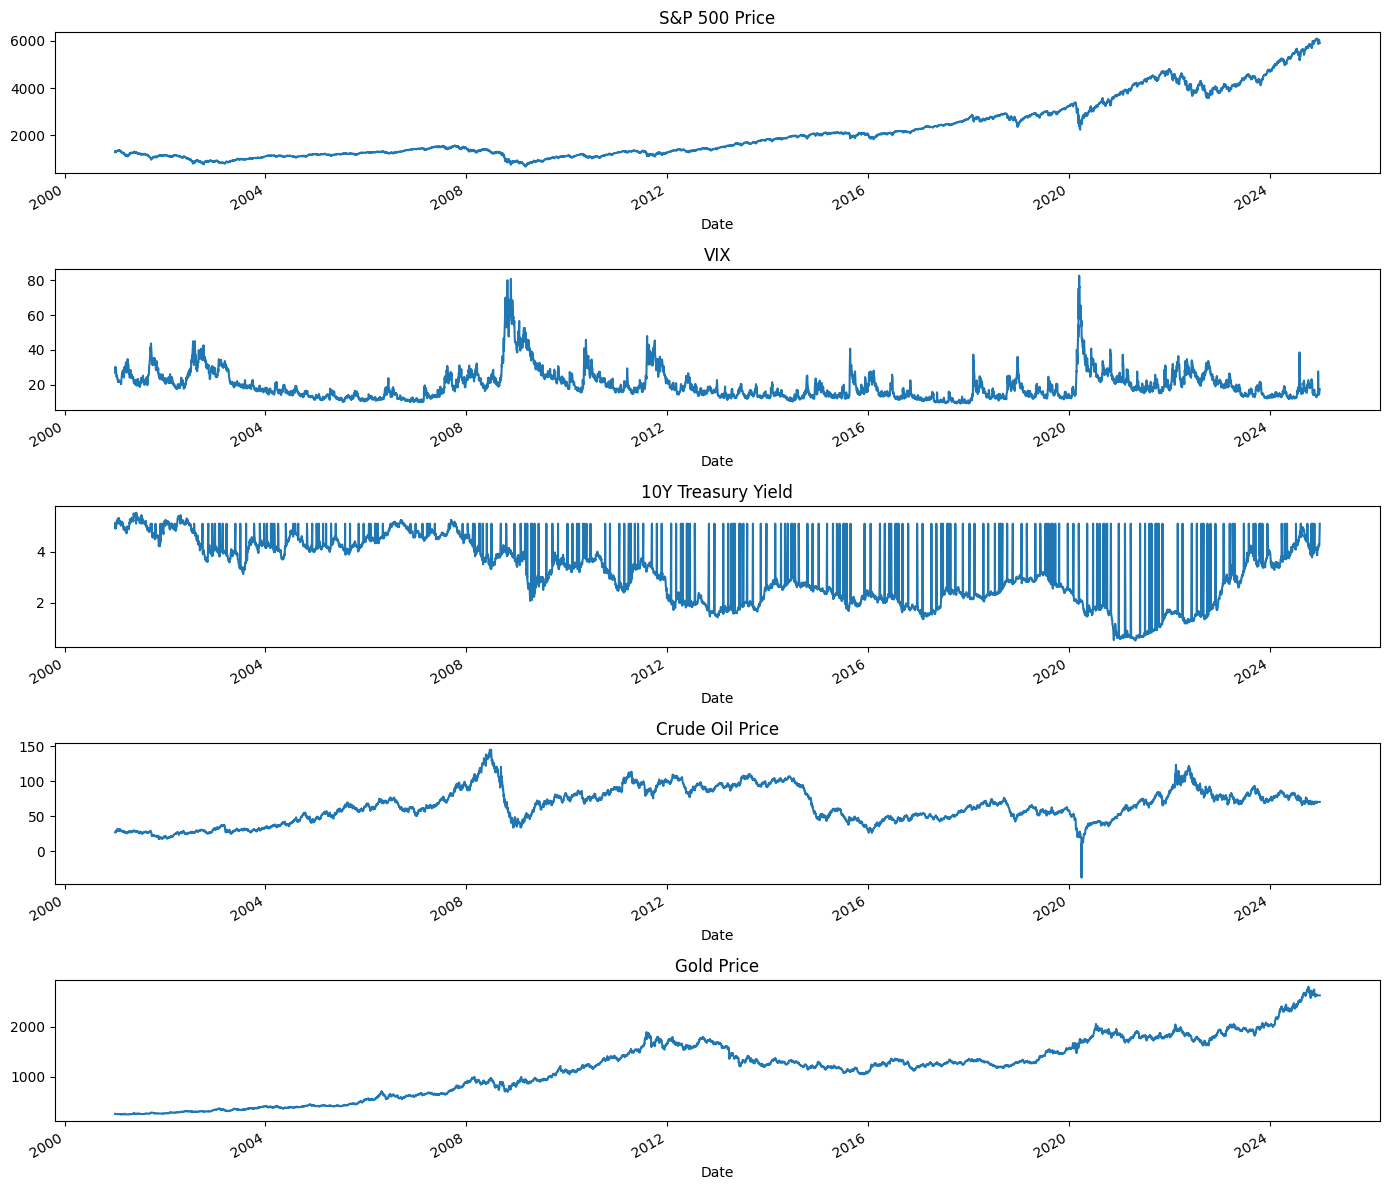

In [7]:

fig, axes = plt.subplots(5, 1, figsize=(14, 12))
df['SP500_Close'].plot(ax=axes[0], title='S&P 500 Price')
df['VIX'].plot(ax=axes[1], title='VIX')
df['DGS10'].plot(ax=axes[2], title='10Y Treasury Yield')
df['Oil'].plot(ax=axes[3], title='Crude Oil Price')
df['Gold'].plot(ax=axes[4], title='Gold Price')
plt.tight_layout()

# Correlation matrix

Text(0.5, 1.0, 'Feature Correlations')

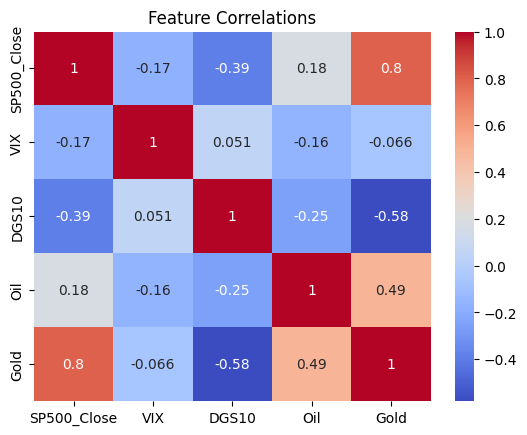

In [8]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlations")

# stationary tests

In [4]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f"ADF Stat: {result[0]:.3f}, p-value: {result[1]:.3f}")
    print("Stationary" if result[1] < 0.05 else "Non-Stationary")

print("\nStationarity Tests:")
check_stationarity(df['SP500_Close'])  # non-stationary
check_stationarity(df['DGS10'])        # non-stationary
check_stationarity(df['VIX'])          # stationary
check_stationarity(df['Gold'])         # non-stationary
check_stationarity(df['Oil'])          # non-stationary


Stationarity Tests:
ADF Stat: 2.659, p-value: 0.999
Non-Stationary
ADF Stat: -2.092, p-value: 0.248
Non-Stationary
ADF Stat: -5.884, p-value: 0.000
Stationary
ADF Stat: 0.264, p-value: 0.976
Non-Stationary
ADF Stat: -2.858, p-value: 0.050
Non-Stationary


# Stationary series

In [5]:
SP500_stationary = np.log(df['SP500_Close'] / df['SP500_Close'].shift(1))
check_stationarity(SP500_stationary.dropna())
DGS10_stationary = df['DGS10'].diff().dropna()  # Second differencing
check_stationarity(DGS10_stationary)
Oil_stationary = np.log(df['Oil'] / df['Oil'].shift(1))
check_stationarity(Oil_stationary.dropna())
Gold_stationary = np.log(df['Gold'] / df['Gold'].shift(1))
check_stationarity(Gold_stationary.dropna())
VIX_stationary = df['VIX']

ADF Stat: -19.338, p-value: 0.000
Stationary
ADF Stat: -16.676, p-value: 0.000
Stationary


/Users/muhammadshahzebali/ali/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ADF Stat: -13.980, p-value: 0.000
Stationary
ADF Stat: -24.933, p-value: 0.000
Stationary


In [10]:
print(type(SP500_stationary))
print(type(VIX_stationary))
print(type(DGS10_stationary))
print(type(Gold_stationary))
print(type(Oil_stationary))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [6]:
df_stationary = pd.DataFrame({
    'SP500_stationary': SP500_stationary,
    'VIX_stationary': VIX_stationary,
    'DGS10_stationary': DGS10_stationary,
    'Oil_stationary': Oil_stationary,
    'Gold_stationary': Gold_stationary
})
df_stationary = df_stationary.dropna()

In [7]:
print(df_stationary.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6033 entries, 2001-01-03 to 2024-12-30
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SP500_stationary  6033 non-null   float64
 1   VIX_stationary    6033 non-null   float64
 2   DGS10_stationary  6033 non-null   float64
 3   Oil_stationary    6033 non-null   float64
 4   Gold_stationary   6033 non-null   float64
dtypes: float64(5)
memory usage: 282.8 KB
None


In [13]:
print(df_stationary.head())

            SP500_stationary  VIX_stationary  DGS10_stationary  \
Date                                                             
2001-01-03          0.048884       26.600000             -0.19   
2001-01-04         -0.010609       26.969999              0.22   
2001-01-05         -0.026593       28.670000             -0.11   
2001-01-08         -0.001920       29.840000             -0.10   
2001-01-09          0.003805       27.990000              0.01   

            Oil_stationary  Gold_stationary  
Date                                         
2001-01-03        0.027200        -0.001491  
2001-01-04        0.008905        -0.002615  
2001-01-05       -0.007117         0.002615  
2001-01-08       -0.023488         0.000000  
2001-01-09        0.013438        -0.001867  


# Normalize Features

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_stationary)

In [10]:
df_scaled = pd.DataFrame(df_scaled, index=df_stationary.index, columns=df_stationary.columns)

In [20]:
print(df_scaled.head())

            SP500_stationary  VIX_stationary  DGS10_stationary  \
Date                                                             
2001-01-03          4.003635        0.803452         -0.286085   
2001-01-04         -0.894079        0.846649          0.331257   
2001-01-05         -2.209982        1.045124         -0.165628   
2001-01-08         -0.178768        1.181721         -0.150571   
2001-01-09          0.292507        0.965734          0.015057   

            Oil_stationary  Gold_stationary  
Date                                         
2001-01-03        1.039223        -0.171514  
2001-01-04        0.333530        -0.274554  
2001-01-05       -0.284481         0.204966  
2001-01-08       -0.915924        -0.034794  
2001-01-09        0.508371        -0.205984  


In [21]:
df_scaled.describe()

,SP500_stationary,VIX_stationary,DGS10_stationary,Oil_stationary,Gold_stationary
count,6.033000e+03,6.033000e+03,6.033000e+03,6.033000e+03,6.033000e+03
mean,1.531088e-17,2.072858e-16,-2.944401e-19,-6.477681e-18,-1.413312e-17
std,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00
min,-1.052967e+01,-1.234993e+00,-6.655245e+00,-1.089521e+01,-9.037534e+00
25%,-3.987526e-01,-6.979458e-01,-6.022846e-02,-4.958024e-01,-4.691402e-01
50%,3.430348e-02,-2.566328e-01,-6.650127e-19,3.019330e-02,8.399428e-03
75%,4.589236e-01,3.854892e-01,6.022846e-02,5.067304e-01,5.348246e-01
max,8.999750e+00,7.351930e+00,6.700416e+00,1.231898e+01,7.888586e+00


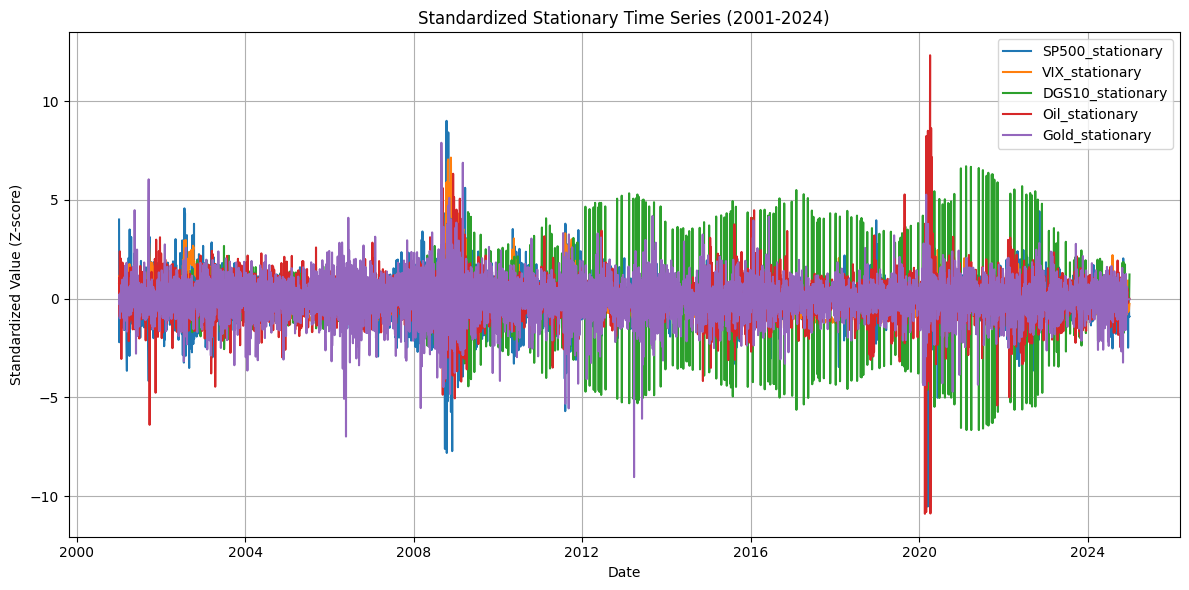

In [22]:
plt.figure(figsize=(12, 6))
for column in df_scaled.columns:
    plt.plot(df_scaled.index, df_scaled[column], label=column)

# Customize the plot
plt.title('Standardized Stationary Time Series (2001-2024)')
plt.xlabel('Date')
plt.ylabel('Standardized Value (Z-score)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [52]:
re = 100* df_scaled['SP500_stationary'].pct_change()

In [11]:
from statsmodels.stats.diagnostic import acorr_ljungbox


# GARCH Model

In [12]:
model = arch_model(df_scaled['SP500_stationary'].dropna(), mean= 'AR', lags= 1, vol='EGARCH', p=1, q=1, o=1)  
garch_result1 = model.fit(update_freq=5) 
print(garch_result1.summary())
df['Conditional_Volatility'] = garch_result1.conditional_volatility  
df['Standardized_Residuals'] = garch_result1.resid / df['Conditional_Volatility']  
lb_test = acorr_ljungbox(df['Standardized_Residuals'].dropna(), lags=[5, 10, 15], return_df=True)
print(lb_test)

Iteration:      5,   Func. Count:     53,   Neg. LLF: 284257798404.516
Iteration:     10,   Func. Count:     95,   Neg. LLF: 6910.515503655879
Iteration:     15,   Func. Count:    132,   Neg. LLF: 6910.51535191648
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6910.515331869511
            Iterations: 17
            Function evaluations: 150
            Gradient evaluations: 17
                          AR - EGARCH Model Results                           
Dep. Variable:       SP500_stationary   R-squared:                       0.008
Mean Model:                        AR   Adj. R-squared:                  0.008
Vol Model:                     EGARCH   Log-Likelihood:               -6910.52
Distribution:                  Normal   AIC:                           13833.0
Method:            Maximum Likelihood   BIC:                           13873.3
                                        No. Observations:                 6032
Date:                We

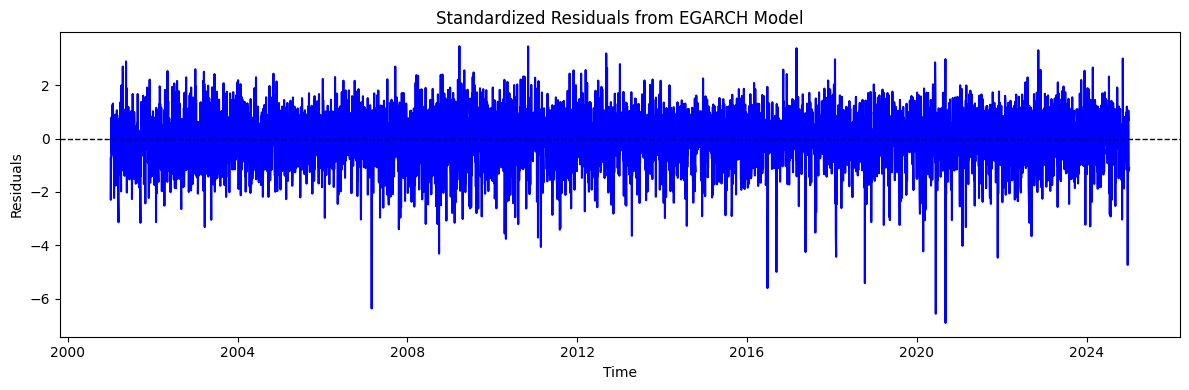

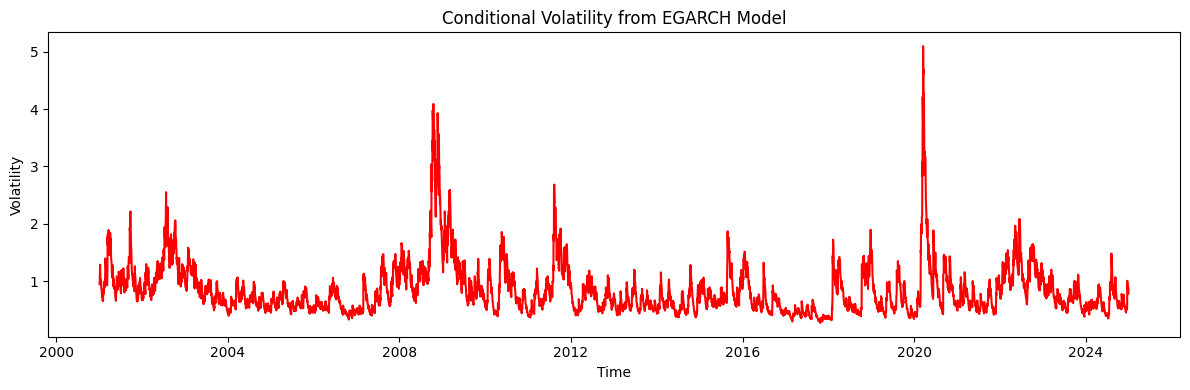

In [13]:
import matplotlib.pyplot as plt

# Plot Standardized Residuals 
plt.figure(figsize=(12, 4))
plt.plot(df['Standardized_Residuals'], color='blue')
plt.title('Standardized Residuals from EGARCH Model') # Model already passed Ljung test so residual seems fine. 
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.tight_layout()
plt.show()

# Plot Conditional Volatility
plt.figure(figsize=(12, 4))
plt.plot(df['Conditional_Volatility'], color='red')
plt.title('Conditional Volatility from EGARCH Model')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.tight_layout()
plt.show()


# Concatenate output with exogenous variables


In [14]:
# Replace negative values with a small epsilon (e.g., 1e-6)
df['Conditional_Volatility'] = df['Conditional_Volatility'].clip(lower=1e-6)

# Now scale it (use MinMaxScaler to [0,1] instead of StandardScaler)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['Conditional_Volatility_scaled'] = scaler.fit_transform(df[['Conditional_Volatility']])
df['Standardized_Residuals_scaled'] = scaler.fit_transform(df[['Standardized_Residuals']])



In [15]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Fit and transform both columns at once
scaler = StandardScaler()
aa = scaler.fit_transform(df[["Conditional_Volatility", "Standardized_Residuals"]])

# Create a new DataFrame from the scaled result
aa_df = pd.DataFrame(aa, index=df.index, columns=["Conditional_Volatility_scaled", "Standardized_Residuals_scaled"])

# Concatenate with original dataframe (optional)
final_scaled_df = pd.concat([df_scaled, aa_df], axis=1)


In [ ]:
#aa = scaler.fit_transform(df[["Conditional_Volatility", "Standardized_Residuals"]])
#aa_df = pd.DataFrame(aa, index=df.index, columns=["Conditional_Volatility_scaled", "Standardized_Residuals_scaled"])

In [ ]:
#final_scaled_df = pd.concat([df_scaled, aa_df], axis=1)

In [16]:
final_scaled_df.describe()

,SP500_stationary,VIX_stationary,DGS10_stationary,Oil_stationary,Gold_stationary,Conditional_Volatility_scaled,Standardized_Residuals_scaled
count,6.033000e+03,6.033000e+03,6.033000e+03,6.033000e+03,6.033000e+03,6.032000e+03,6.032000e+03
mean,1.413312e-17,1.884416e-16,-8.833202e-19,-2.355520e-18,-1.648864e-17,-7.538915e-17,1.649138e-17
std,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00
min,-1.052967e+01,-1.234993e+00,-6.655245e+00,-1.089521e+01,-9.037534e+00,-1.286423e+00,-6.897850e+00
25%,-3.987526e-01,-6.979458e-01,-6.022846e-02,-4.958024e-01,-4.691402e-01,-6.560119e-01,-5.542729e-01
50%,3.430348e-02,-2.566328e-01,-6.650127e-19,3.019330e-02,8.399428e-03,-2.657135e-01,5.647574e-02
75%,4.589236e-01,3.854892e-01,6.022846e-02,5.067304e-01,5.348246e-01,3.593851e-01,6.314096e-01
max,8.999750e+00,7.351930e+00,6.700416e+00,1.231898e+01,7.888586e+00,9.548738e+00,3.474694e+00


In [17]:
final_features_clean = final_scaled_df.dropna()  
print(final_features_clean.head())  

            SP500_stationary  VIX_stationary  DGS10_stationary  \
Date                                                             
2001-01-04         -0.894079        0.846649          0.331257   
2001-01-05         -2.209982        1.045124         -0.165628   
2001-01-08         -0.178768        1.181721         -0.150571   
2001-01-09          0.292507        0.965734          0.015057   
2001-01-10          0.764705        0.826802          0.060228   

            Oil_stationary  Gold_stationary  Conditional_Volatility_scaled  \
Date                                                                         
2001-01-04        0.333530        -0.274554                       0.229443   
2001-01-05       -0.284481         0.204966                       0.318152   
2001-01-08       -0.915924        -0.034794                       0.992915   
2001-01-09        0.508371        -0.205984                       0.874314   
2001-01-10        2.390629        -0.999406                       0.6

In [18]:
print(final_features_clean.isnull().sum())  
# Expected: All zeros  

print(final_features_clean.describe())  
# Check min/max/mean of scaled features (should be ~N(0,1))  

SP500_stationary                 0
VIX_stationary                   0
DGS10_stationary                 0
Oil_stationary                   0
Gold_stationary                  0
Conditional_Volatility_scaled    0
Standardized_Residuals_scaled    0
dtype: int64
       SP500_stationary  VIX_stationary  DGS10_stationary  Oil_stationary  \
count       6032.000000     6032.000000      6.032000e+03     6032.000000   
mean          -0.000664       -0.000133      4.742792e-05       -0.000172   
std            0.998836        1.000112      1.000159e+00        1.000076   
min          -10.529667       -1.234993     -6.655245e+00      -10.895213   
25%           -0.399048       -0.697946     -6.022846e-02       -0.496218   
50%            0.034083       -0.256633     -6.650127e-19        0.030083   
75%            0.458696        0.384614      6.022846e-02        0.506686   
max            8.999750        7.351930      6.700416e+00       12.318979   

       Gold_stationary  Conditional_Volatility_s

In [19]:
final_features_clean

,SP500_stationary,VIX_stationary,DGS10_stationary,Oil_stationary,Gold_stationary,Conditional_Volatility_scaled,Standardized_Residuals_scaled
Date,,,,,,,
2001-01-04,-0.894079,0.846649,0.331257,0.333530,-0.274554,0.229443,-0.728676
2001-01-05,-2.209982,1.045124,-0.165628,-0.284481,0.204966,0.318152,-2.284518
2001-01-08,-0.178768,1.181721,-0.150571,-0.915924,-0.034794,0.992915,-0.218054
2001-01-09,0.292507,0.965734,0.015057,0.508371,-0.205984,0.874314,0.236982
2001-01-10,0.764705,0.826802,0.060228,2.390629,-0.999406,0.684408,0.685676
...,...,...,...,...,...,...,...
2024-12-23,0.577014,-0.343027,0.210800,-0.009945,-0.034794,0.163221,0.683523
2024-12-24,0.883376,-0.636069,-0.060228,-0.009945,-0.034794,0.049402,1.060486
2024-12-26,-0.054136,-0.582364,-0.045171,-0.009945,-0.034794,-0.046111,-0.007040


In [36]:
final_features_clean.isnull().sum()

SP500_stationary                 0
VIX_stationary                   0
DGS10_stationary                 0
Oil_stationary                   0
Gold_stationary                  0
Conditional_Volatility_scaled    0
Standardized_Residuals_scaled    0
dtype: int64

In [35]:
final_features_clean['Conditional_Volatility_scaled'].isnull().sum()

0

# Embedding Calculation

In [20]:
import torch
import torch.nn as nn

class FeatureEmbedding(nn.Module):
    def __init__(self, num_features, embedding_dim=2):
        super().__init__()
        # Each feature gets its own embedding layer (learnable matrix)
        self.embeddings = nn.ModuleList([
            nn.Linear(1, embedding_dim) for _ in range(num_features)
        ])
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, num_features)
        # Project each feature to 2D and sum them
        embedded = []
        for i in range(x.shape[-1]):
            # For feature `i`, extract (batch_size, seq_len, 1) and project to 2D
            feature = x[..., i:i+1]  # Shape: (batch_size, seq_len, 1)
            embedded_feature = self.embeddings[i](feature)  # Shape: (batch_size, seq_len, 2)
            embedded.append(embedded_feature)
        
        # Sum all feature embeddings: (batch_size, seq_len, 2)
        summed_embedding = torch.sum(torch.stack(embedded, dim=0), dim=0)
        return summed_embedding

# Add positional encoding

In [21]:
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim=2, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)  # Shape: (max_len, 1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-math.log(10000.0) / embedding_dim))
        pe = torch.zeros(max_len, embedding_dim)
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices: sine
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices: cosine
        self.register_buffer('pe', pe)  # Not a learnable parameter
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, embedding_dim)
        seq_len = x.shape[1]
        return x + self.pe[:seq_len, :]  # Add positional encoding

In [31]:
class VolatilityTransformer(nn.Module):
    def __init__(self, num_features, embedding_dim=2):
        super().__init__()
        # Existing components
        self.feature_embedding = FeatureEmbedding(num_features, embedding_dim)
        self.positional_encoding = PositionalEncoding(embedding_dim)
        
        # Attention components
        self.Wq = nn.Linear(embedding_dim, embedding_dim)  # Query weights
        self.Wk = nn.Linear(embedding_dim, embedding_dim)  # Key weights
        self.Wv = nn.Linear(embedding_dim, embedding_dim)  # Value weights
        self.layer_norm = nn.LayerNorm(embedding_dim)      # Layer normalization

        # MLP for final prediction
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, 16),  # Hidden layer
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 1)               # Output 1 value per timestep
        )

    def forward(self, x):
        # x shape: (batch_size, seq_len, 7)
        conditional_volatility = x[..., 5]  # 6th column: Conditional_Volatility_scaled
        
        # 1. Feature embedding + positional encoding
        embedded = self.feature_embedding(x)          # (batch, seq_len, 2)
        encoded = self.positional_encoding(embedded)  # (batch, seq_len, 2)
        
        # 2. Compute Q/K/V projections
        Q = self.Wq(encoded)
        K = self.Wk(encoded)
        V = self.Wv(encoded)
        
        # 3. Attention scores with volatility scaling
        d_k = K.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (d_k ** 0.5)
        scaled_scores = scores * torch.sqrt(conditional_volatility + 1e-7).unsqueeze(-1)
        
        # 4. Softmax + weighted sum
        attention_weights = F.softmax(scaled_scores, dim=-1)
        attention_output = torch.matmul(attention_weights, V)
        
        # 5. Residual connection + layer normalization
        transformer_output = self.layer_norm(attention_output + encoded)
        
        # 6. Final volatility prediction with MLP
        predictions = self.mlp(transformer_output)  # (batch_size, seq_len, 1)
        return predictions.squeeze(-1)  # (batch_size, seq_len)

# Pass data through

In [32]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split

# Convert DataFrame to numpy arrays
data = final_features_clean.values  # Shape: (num_samples, 7)
target = final_features_clean["Conditional_Volatility_scaled"].values  # Target variable

# Create sequences (e.g., use 30 days to predict next day)
sequence_length = 30
X, y = [], []
for i in range(len(data) - sequence_length):
    X.append(data[i:i+sequence_length])  # Input: (sequence_length, 7)
    y.append(target[i+sequence_length])  # Target: scalar

X = np.array(X)  # Shape: (num_samples, sequence_length, 7)
y = np.array(y)  # Shape: (num_samples,)

# Split into train/test (preserve temporal order)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # Do not shuffle time series!
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [34]:
from torch.utils.data import DataLoader, TensorDataset

# Initialize model with gradient clipping and smaller learning rate
model = VolatilityTransformer(num_features=7)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()

# Training loop with gradient clipping
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        # Forward pass with NaN checks
        predictions = model(batch_X)
        assert not torch.isnan(predictions).any(), "NaNs in predictions!"
        
        preds = predictions[:, -1]
        loss = criterion(preds, batch_y)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        
        total_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        test_preds = model(X_test)[:, -1]
        test_mae = criterion(test_preds, y_test).item()
    
    print(f"Epoch {epoch+1} | Train MAE: {total_loss/len(train_loader):.4f} | Test MAE: {test_mae:.4f}")

AssertionError: NaNs in predictions!

In [27]:
model.eval()
with torch.no_grad():
    # Test set predictions
    test_preds = model(X_test)[:, -1]  # Last timestep predictions
    
    # Inverse scaling if needed (depends on how you scaled "Conditional_Volatility_scaled")
    # test_preds_original_scale = test_preds * std + mean
    
    # Calculate MAE
    mae = torch.abs(test_preds - y_test).mean().item()
    print(f"Final Test MAE: {mae:.4f}")

Final Test MAE: nan


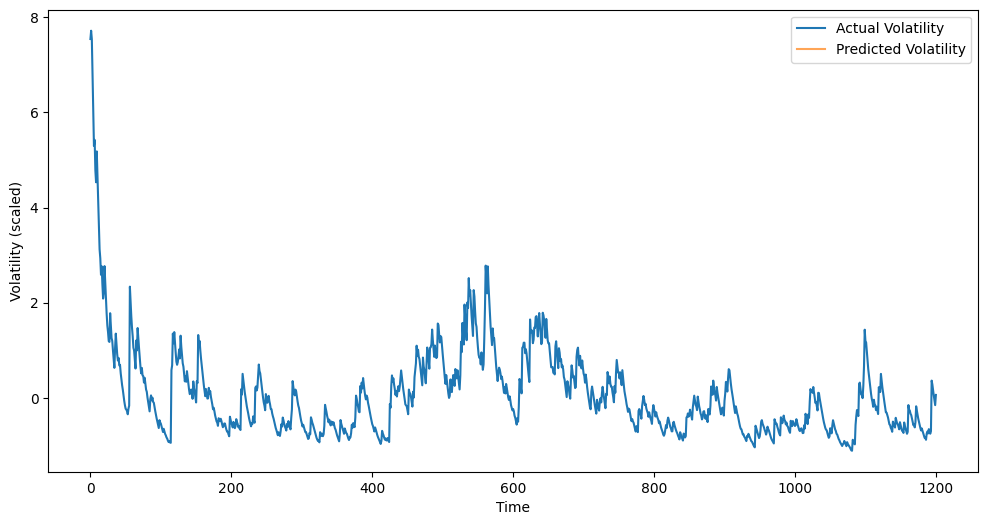

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.numpy(), label="Actual Volatility")
plt.plot(test_preds.numpy(), label="Predicted Volatility", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Volatility (scaled)")
plt.legend()
plt.show()